In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import string
import nltk 
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, classification_report
import emoji

# Download NLTK stopwords
try:
    stopwords.words('english')
    wordnet.synsets('hello')       
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')

In [27]:
# Reading the CSV file
data = pd.read_csv('spam.csv', encoding='latin1', names=['Target','Message','DropColumn1','DropColumn2','DropColumn3'])

# Drop the unnecessary columns in place
data.drop(['DropColumn1','DropColumn2','DropColumn3'], axis=1, inplace=True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Target   5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [29]:
data.describe()

,Target,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### Exploratory Data Analysis

C:\Users\SS\AppData\Local\Temp\ipykernel_19592\3177855365.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=data, palette=['#f56389', '#f0cba3'])


Text(0, 0.5, 'Occurence of Target Classes')

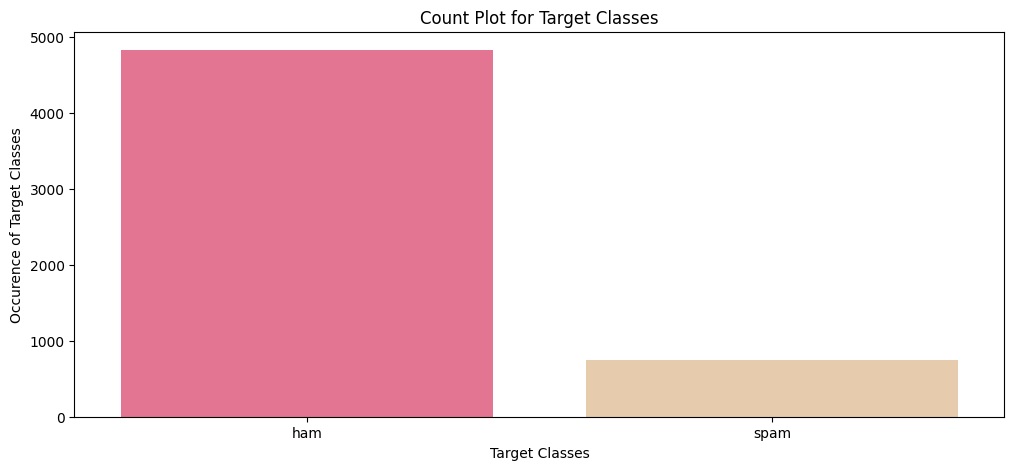

In [30]:
plt.figure(figsize=(12,5))

sns.countplot(x='Target', data=data, palette=['#f56389', '#f0cba3'])

plt.title("Count Plot for Target Classes")
plt.xlabel("Target Classes")
plt.ylabel("Occurence of Target Classes")

### Data PreProcessing

In [31]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when. TFW internet slang often goes in a caption to an image.",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "TFYP": "I feel your pain",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [32]:
# Data Preprocessing Function
def process_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Replace all non-alphanumeric characters with a space
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
        
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

data['Message'] = data['Message'].apply(process_text)

In [33]:
# Treating the Chat Words
def treat_chat_word(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

data['Message'] = data['Message'].apply(treat_chat_word)

In [34]:
# Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['Message'] = data['Message'].apply(remove_emoji)

In [35]:
# Lematizing The Message

lemmatizer = WordNetLemmatizer()

def lematize_word(text):
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text
    

data['Message'] = data['Message'].apply(lematize_word)

### Vectorization

In [36]:
# Vectorizing Messages using TFIDF

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(data['Message']).toarray()

# Label Encoding the Target using Label Enocder class
encoder = LabelEncoder()
Y = encoder.fit_transform(data['Target'])


### Building Models

In [37]:
# Spliting the Data into Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

multinomial = MultinomialNB()
svm = SVC(kernel='linear')

multinomial.fit(X_train, Y_train)
svm.fit(X_train, Y_train)

print("Multinomial NB score: ",multinomial.score(X_train, Y_train))
print("SVM score: ",svm.score(X_train, Y_train))

Multinomial NB score:  0.9791339466008526
SVM score:  0.9957370428539376


### Predicting New Target Values

In [38]:
Y_pred_NB = multinomial.predict(X_test)
Y_pred_SVC = svm.predict(X_test)

In [39]:
# Evaluation
accuracy = accuracy_score(Y_test, Y_pred_NB)
print(f"NB Accuracy: {accuracy:.2f}")
accuracy = accuracy_score(Y_test, Y_pred_SVC)
print(f"SVM Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report for Naive Bayes")
print(classification_report(Y_test, Y_pred_NB))
print("Classification Report for Support Vector Machines")
print(classification_report(Y_test, Y_pred_SVC))

NB Accuracy: 0.97
SVM Accuracy: 0.98
Classification Report for Naive Bayes
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.85       150

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115

Classification Report for Support Vector Machines
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.98      0.83      0.90       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.94      1115
weighted avg       0.98      0.98      0.97      1115

